In [31]:
import warnings
warnings.filterwarnings("ignore")

In [32]:
import math 
import os
from pathlib import Path
import random
from tempfile import TemporaryDirectory
import time

from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers.models.gpt2.tokenization_gpt2 import bytes_to_unicode
from transformers import DataCollatorWithPadding
from transformers import BertConfig, BertForSequenceClassification, PreTrainedTokenizerFast
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from tokenizers import normalizers
from tokenizers.decoders import ByteLevel as ByteLevelDecoder
from tokenizers.normalizers import NFD, Lowercase, NFKC
from tokenizers import pre_tokenizers
from tokenizers.pre_tokenizers import Whitespace, ByteLevel
from tokenizers import Tokenizer, models, trainers
from tqdm.auto import tqdm

In [33]:
os.environ["WANDB_DISABLED"] = str("true")
os.environ["TOKENIZERS_PARALLELISM"] = str("true")

There is no description about the dataset. But I like it, since it contains of 3 datasets (human, dog, chimpanzee). Each datasets has a dna sequence and 7 possible classes. Each dna sequence is describes by the nucleotides A (adenine) C (cytosine) G (guanine) T (thymine). N also occurs in the dataset and specifics non-dertermined nucleotides. Please have a look for the dataset introduction [here](https://www.kaggle.com/code/tarunsolanki/classifying-dna-sequence-using-ml). 

This notebook is part of a small work project. Please have a look at [part 1](https://www.kaggle.com/steffenhaeussler/dna-sequence-classification-part-1/) , [part 2](https://www.kaggle.com/steffenhaeussler/dna-sequence-classification-part-2) and [part 4](https://www.kaggle.com/steffenhaeussler/dna-sequence-classification-part-4). In this part, I will use a huggingface implemented  TransformerEncoder network. This doesn't make much sense here, since the sequence length is too big for a transformer. But I picked this dataset as an example and want to compare it with other methods. Iwant to implement a Transformer from scratch (part 4) and need an implementation to compare my results. 

## Data preparation

In [34]:
def clean_text(examples):
    examples = examples["text"].split("\t")
    return {"text": examples[0], "label": examples[1]}

We need to create the dataset from the text file and also, remove the first line.

In [35]:
dataset = load_dataset("text", data_files="/kaggle/input/dna-sequence-dataset/human.txt", 
                       split="train[1:]", 
                       streaming=False)

dataset = dataset.map(clean_text)
n_classes = len(set(dataset['label']))

  0%|          | 0/4380 [00:00<?, ?ex/s]

I'm not sure, if the datasets library will allow stratified splits. Here I create a train - val - test dataset.

In [36]:
seed=83110
split = [0.8, 0.1, 0.1]

data = pd.DataFrame(dataset)

X_train, X_test, y_train, y_test = train_test_split(
    data['text'],
    data['label'],
    test_size=split[1],
    train_size=1-split[1],
    random_state=seed,
    shuffle=True,
    stratify=data['label'],
)

n_ratio = X_test.shape[0]/X_train.shape[0]

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=n_ratio,
    train_size=1-n_ratio,
    random_state=seed,
    shuffle=True,
    stratify=y_train,
)

In [37]:
print(X_train.shape[0], X_val.shape[0], X_test.shape[0])

3504 438 438


Out of convenience, we store the splits as csv files. I also run into some numpy conversion errors with the datasets library and this just works.

In [38]:
pd.DataFrame({"text": X_train, "label": y_train}).to_csv("/kaggle/working/train.csv", index=False)
pd.DataFrame({"text": X_val, "label": y_val}).to_csv("/kaggle/working/val.csv", index=False)
pd.DataFrame({"text": X_test, "label": y_test}).to_csv("/kaggle/working/test.csv", index=False)

In [39]:
dataset = load_dataset("csv", data_files={'train': ["/kaggle/working/train.csv"],
                                          'val': ["/kaggle/working/val.csv"],
                                         'test': ["/kaggle/working/test.csv"],
                                         },
                      split=None)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d0a8a5fa0d01b167/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Tokenizer

The transformers library is quite handy. Setting up a tokenizer is not really needed, but since I have already the code and the overhead is not that big, I just go for it.

In [40]:
tokenizer = Tokenizer(models.BPE())

tokenizer.normalizer = normalizers.Sequence([
    NFD(),
])

# Our tokenizer also needs a pre-tokenizer responsible for converting the input to a ByteLevel representation.
tokenizer.pre_tokenizer = pre_tokenizers.Sequence([
                                        ByteLevel(add_prefix_space=False), 
                                        Whitespace()
                                        ])

tokenizer.decoder = ByteLevelDecoder()

We have to deal only with 5 characters.

In [41]:
base_vocab = ["A", "C", "G", "T", "N"]
print(f'Size of our base vocabulary: {len(base_vocab)}')

Size of our base vocabulary: 5


And with the vocab_size of 10, I will make sure, that we only use the base vocabulary. The other 5 items in the vocab are the special tokens. A small experiment for the future will be a bigger vocab size and how it affects the model performance. My assumption is, that the performance should improve a lot, since we are able to use more information in our training.

In [42]:
vocab_size=10

trainer = trainers.BpeTrainer(vocab_size=vocab_size, 
                              show_progress=True, 
                              initial_alphabet=base_vocab,
                              special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])


In [43]:
iter_dataset = iter(dataset['train'])

def batch_iterator(batch_size=10):
    for _ in tqdm(range(0, round(len(dataset['train']),-1), batch_size)):
        yield [next(iter_dataset)['text'] for _ in range(batch_size)]

In [44]:
tokenizer.train_from_iterator(batch_iterator(), trainer=trainer)

  0%|          | 0/350 [00:00<?, ?it/s]

A small test and the encoder does, what it should do. It encodes every character. Again, this can be solved with an one-liner.

In [45]:
output = tokenizer.encode("ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA")
print(output.tokens)
print(output.ids)


['A', 'T', 'G', 'C', 'C', 'C', 'C', 'A', 'A', 'C', 'T', 'A', 'A', 'A', 'T', 'A', 'C', 'T', 'A', 'C', 'C', 'G', 'T', 'A', 'T', 'G', 'G', 'C', 'C', 'C', 'A', 'C', 'C', 'A', 'T', 'A', 'A', 'T', 'T', 'A', 'C', 'C', 'C', 'C', 'C', 'A']
[5, 9, 7, 6, 6, 6, 6, 5, 5, 6, 9, 5, 5, 5, 9, 5, 6, 9, 5, 6, 6, 7, 9, 5, 9, 7, 7, 6, 6, 6, 5, 6, 6, 5, 9, 5, 5, 9, 9, 5, 6, 6, 6, 6, 6, 5]


In [46]:
tokenizer.save(f"/kaggle/working/tokenizer.json")

In [47]:
tk_tokenizer = Tokenizer.from_file(f"/kaggle/working/tokenizer.json")
tokenizer = PreTrainedTokenizerFast(tokenizer_object=tk_tokenizer)

tokenizer.add_special_tokens({'pad_token': "[PAD]",
                              'unk_token': "[UNK]",
                              'sep_token': "[SEP]",
                              'cls_token': "[CLS]",
                              'bos_token': "[CLS]",
                              'eos_token': "[SEP]",
                              'mask_token': "[MASK]"
                             })

0

## Data

In [48]:
max_length=256

The dataset is small, so we can tokenize the dna sequence before and keep it in memory. We also need to truncate and pad our dna sequence. The dna sequences are much longer than it could be processed with a transformer model.

In [49]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=max_length)

In [50]:
tokenized_ds = dataset.map(preprocess_function, batched=True)

tokenized_ds = tokenized_ds.with_format("torch")

data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=max_length)


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [51]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3504
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 438
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 438
    })
})

## Model

We create a small text classification model for fast iteration. This is playing around, just to see, how well we can perform on a subset of the dna sequence.

In [52]:
max_position_embeddings = 512
hidden_size = 768
num_hidden_layers = 2 #12
num_attention_heads = 4 # 12
intermediate_size = 3072
drop_out = 0.1

model_path = "/kaggle/working/model"

In [53]:
config = BertConfig(
    num_labels=n_classes,
    # mask_token_id = 4,
    bos_token_id = 1,                          
    sep_token_id = 2,                          
    #  pad_token_id = 3,
    eos_token_id = 2,

    max_position_embeddings = max_position_embeddings,

    hidden_size = hidden_size,                          
    num_hidden_layers = num_hidden_layers,                          
    num_attention_heads = num_attention_heads,                          
    intermediate_size = intermediate_size,

    hidden_act = 'gelu',
    hidden_dropout_prob = drop_out,
    attention_probs_dropout_prob = drop_out,

    type_vocab_size = 2,
    initializer_range = 0.02,
    layer_norm_eps = 1e-12, 

    vocab_size = vocab_size,

    use_cache = True,                          
    classifier_dropout = None,
    onnx_export = False)

Setting up the classification model and it only has 15 million parameters. This is the effect of the small vocab_size and attention dimension of 256.

In [54]:
model = BertForSequenceClassification(config=config)
print(f"n of parameters: {model.num_parameters():_}")

n of parameters: 15_175_687


## Model training

Basic BERT training parameters. We don't have much data, so I set up the epoch to 50. Also, increasing the learning_rate didn't help.

In [86]:
learning_rate = 1e-4 # bert
weight_decay = 0.9 # bert
lr_scheduler_type = "linear"

num_train_epochs = 50 # 5 but training set is small

train_batch_size = 32
eval_batch_size = 32

gradient_accumulation_steps=2
eval_accumulation_steps=2

warmup_steps = 0

adam_beta1 = 0.9 # bert
adam_beta2 = 0.999 # bert
adam_epsilon = 1e-8 # bert
max_grad_norm = 1.0 # bert

In [87]:
training_args = TrainingArguments(
    output_dir=model_path,
    overwrite_output_dir=True,

    learning_rate=learning_rate,
    weight_decay=weight_decay,
    lr_scheduler_type=lr_scheduler_type,
    num_train_epochs=num_train_epochs,
    adam_beta1=adam_beta1,
    adam_beta2=adam_beta2,
    adam_epsilon=adam_epsilon,
    max_grad_norm=max_grad_norm,
    
    evaluation_strategy="epoch",
    
    per_device_train_batch_size=train_batch_size, # depends on memory
    per_device_eval_batch_size=eval_batch_size,
        
    gradient_accumulation_steps=gradient_accumulation_steps,
#     eval_accumulation_steps=eval_accumulation_steps,

    save_strategy="epoch",
    save_total_limit=3,
    
    prediction_loss_only=False,
    report_to="tensorboard",

    log_level="warning",
    logging_strategy="epoch",
    
    fp16 = True,
    fp16_full_eval=True,
    
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    
    push_to_hub=False,
    dataloader_pin_memory=True,
)


In [88]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(y_true=labels, y_pred=predictions)
    recall = recall_score(y_true=labels, y_pred=predictions, average='weighted')
    precision = precision_score(y_true=labels, y_pred=predictions, average='weighted')
    f1 = f1_score(y_true=labels, y_pred=predictions, average='weighted')    
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [89]:
early_stopping = EarlyStoppingCallback(early_stopping_patience = 3,
                                       early_stopping_threshold = 0.02)

callbacks = [early_stopping]

In [90]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['val'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks=callbacks
)


In [91]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.248400,1.301687,0.698630,0.714334,0.698630,0.702276
2,0.325000,1.236253,0.703196,0.720062,0.703196,0.706724
3,0.316600,1.206020,0.739726,0.749802,0.739726,0.736998
4,0.310400,1.217715,0.746575,0.753494,0.746575,0.747329
5,0.326600,1.173711,0.753425,0.768095,0.753425,0.755264
6,0.304200,1.212043,0.730594,0.742261,0.730594,0.727150
7,0.286400,1.119050,0.751142,0.754559,0.751142,0.751727
8,0.332200,1.201661,0.757991,0.764935,0.757991,0.757998
9,0.298900,1.122740,0.762557,0.767083,0.762557,0.761985
10,0.289700,1.172439,0.762557,0.769756,0.762557,0.762454


TrainOutput(global_step=550, training_loss=0.3038360127535733, metrics={'train_runtime': 158.581, 'train_samples_per_second': 1104.798, 'train_steps_per_second': 17.341, 'total_flos': 795117857587200.0, 'train_loss': 0.3038360127535733, 'epoch': 10.0})

In [92]:
# Sauvegarde du modèle et du tokenizer
model.save_pretrained("./final_model")
tokenizer.save_pretrained("./final_model")

trainer.evaluate()

{'eval_loss': 1.1191972494125366,
 'eval_accuracy': 0.7511415525114156,
 'eval_precision': 0.7545594454428163,
 'eval_recall': 0.7511415525114156,
 'eval_f1': 0.7517265420396412,
 'eval_runtime': 0.7738,
 'eval_samples_per_second': 566.063,
 'eval_steps_per_second': 18.093,
 'epoch': 10.0}

## Test

Let's have a look at the test data:

In [93]:
y_hat = trainer.predict(tokenized_ds['test'])

I definitely expected worse. An weighted f1-score is not too bad, considering, that we only use a short sequence of the dna. Also, we can not predict class 5 correct. Probably, we don't have enough training data or the sequence is specific and there is not enough information in our used data.

In [94]:
for weight in ['micro', 'macro', 'weighted']:
    f1 = f1_score(np.argmax(y_hat[0], axis=1), tokenized_ds['test']['label'], average=weight)
    print(f"{weight}: {f1}")

micro: 0.7374429223744292
macro: 0.7139534297690846
weighted: 0.736213253533745


In [95]:
print(classification_report(tokenized_ds['test']['label'], np.argmax(y_hat[0], axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.64      0.68        53
           1       0.61      0.85      0.71        54
           2       0.62      0.71      0.67        35
           3       0.84      0.70      0.76        67
           4       0.69      0.69      0.69        71
           5       0.71      0.62      0.67        24
           6       0.84      0.80      0.82       134

    accuracy                           0.74       438
   macro avg       0.72      0.72      0.71       438
weighted avg       0.75      0.74      0.74       438



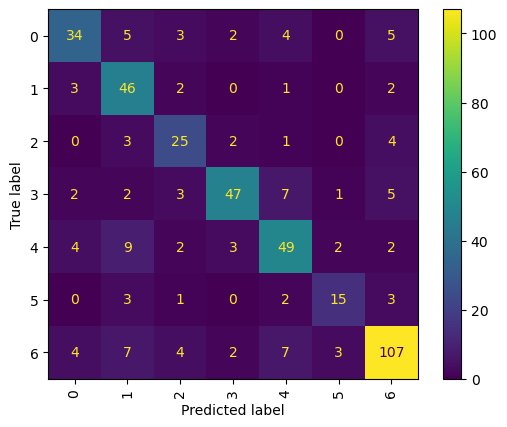

In [96]:
cm = confusion_matrix(tokenized_ds['test']['label'], np.argmax(y_hat[0], axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(n_classes)))

disp.plot(xticks_rotation="vertical") 